In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

sam_checkpoint = "./../../segmentanything/Scripts/sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
mask_generator = SamAutomaticMaskGenerator(sam)

In [2]:
def findVertex(mask: np.ndarray, max_iter = 20):
    thresh = mask.astype(np.uint8) * 255
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    factor = 0.01
    for _ in range(max_iter):
        epsilon = factor * cv2.arcLength(contours[0], True)
        approx = cv2.approxPolyDP(cv2.convexHull(contours[0]), epsilon, True)
        if len(approx) == 4: return approx
        if len(approx) > 4: factor += 0.005
        else: factor -= 0.005
    raise Exception("beyound max_iter")

In [3]:
def segment(image: np.ndarray):
    masks = mask_generator.generate(image)
    max_img, max_val, max_idx, max_part, max_mask = None, 0, None, None, None
    for idx, ann in enumerate(sorted(masks, key=(lambda x: x['area']), reverse=True)):
        part = np.sum(ann['segmentation'] != 0) / (ann['segmentation'].shape[0] * ann['segmentation'].shape[1])
        if part < 0.005: continue
        mask_img = np.where(ann['segmentation'][:,:,None][:,:,(0,0,0)], image, 0)
        mask_hsv = cv2.cvtColor(mask_img, cv2.COLOR_BGR2HSV)
        val = max(
            (np.sum(cv2.inRange(mask_hsv, np.array([105, 161, 108]), np.array([112, 255, 255])) != 0) / np.sum(ann['segmentation'] != 0)),
            (np.sum(cv2.inRange(mask_hsv, np.array([38, 30, 133]), np.array([100, 164, 218])) != 0) / np.sum(ann['segmentation'] != 0))
        )
        if val > 0.7: continue

        try:findVertex(ann['segmentation'])
        except:continue

        if val > max_val:
            max_val = val
            max_img = mask_img
            max_idx = idx
            max_part = part
            max_mask = ann['segmentation']
    return max_mask

In [84]:
def sort_points(points: list):
    """
    对四边形的四个顶点按照（左上、右上、右下、左下）的顺序进行排序
    """
    tmp = sorted(points)
    left, right = tmp[:2], tmp[2:]
    left.sort(key=lambda x:x[1])
    right.sort(key=lambda x:x[1])
    return [left[0], right[0], right[1], left[1]]

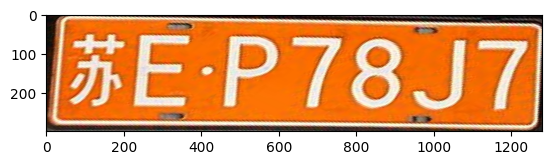

In [87]:
image0 = cv2.imread('./../../OIP-C.jpg')
image = cv2.resize(image0, (0,0), fx=0.5, fy=0.5)
mask = segment(image)
im = image0.copy()
vertexs = findVertex(mask) * 2
# cv2.drawContours(im, [vertexs], -1, (255, 0, 0), 2)
# plt.imshow(im)

width, height = 1280, 300 # 车牌号的形状
pts1 = np.array(sort_points(np.squeeze(vertexs).astype(np.float32).tolist()), dtype=np.float32)
pts2 = np.float32([[0, 0],[width,0],[width, height],[0,height]])
M = cv2.getPerspectiveTransform(pts1, pts2)
dst = cv2.warpPerspective(image0, M, (width, height))
plt.imshow(dst)